<h1>Background and Scope of Project</h1>

In the Pokémon series of video games, there is an area called the Safari Zone. This area has a minigame in which the player must catch a certain amount of Pokémon within a walking distance limit. Encounters with Pokémon are random. When an encounter takes place, the player has the option to throw a Poké ball (which catches the Pokémon, ending the encounter), mud (which has a chance the rate of escape and the catch rate), and bait (which decreases the rate of escape and has a chance to decrease the catch rate as well).  This project will focus on finding an optimal strategy of balancing bait and mud which gives the best rate of catching a Pokémon.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def apply_stage_modifier(stage):
    # Clamp stage between -6 and +6
    stage = max(-6, min(6, stage))
    if stage >= 0:
        return (2 + stage) / 2
    else:
        return 2 / (2 - stage)


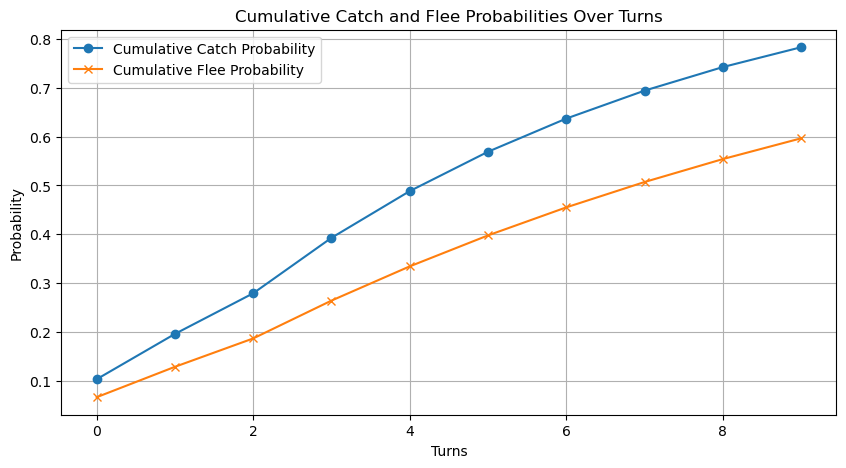

In [15]:

def setup_markov_chain(base_flee_rate, base_catch_rate, flee_stage=0, catch_stage=0, max_turns=10, action_sequence=None):
    """
    Simulates Safari Zone catch/flee dynamics with bait/mud effects.

    Parameters:
    - flee_stage, catch_stage: Initial modifier stages for flee and catch.
    - max_turns: Number of turns to simulate.
    - action_sequence: List of actions per turn: "ball", "bait", or "mud".

    Returns:
    - Dictionary of catch/flee progress and final state probabilities.
    """
    if action_sequence is None:
        action_sequence = ["ball"] * max_turns

    # Lists for tracking progression
    flee_progress = []
    catch_progress = []

    # Initial state vectors: [still in field, absorbed]
    state_flee = np.array([1.0, 0.0])
    state_catch = np.array([1.0, 0.0])

    for t in range(max_turns):
        action = action_sequence[t]

        # Apply bait/mud effects probabilistically (90%)
        if action == "bait":
            flee_stage -= 1
            catch_stage -= 0.9 #Use the expected value of the catch stage increase
        elif action == "mud":
            catch_stage += 1
            flee_stage += 0.9 #Use the expected value of the flee stage increase
        elif action == "ball":
            # Ball action does not change stages, just applies the current rates
            pass
        # Apply stat stage modifiers
        flee_mod = apply_stage_modifier(flee_stage)
        catch_mod = apply_stage_modifier(catch_stage)

        

        # Apply modifiers and clip to [0,1]
        flee_rate = min(1.0, base_flee_rate * flee_mod)
        catch_rate = min(1.0, base_catch_rate * catch_mod)

        # Build transition matrices
        T_flee = np.array([
            [1 - flee_rate, flee_rate],
            [0, 1]
        ])
        T_catch = np.array([
            [1 - catch_rate, catch_rate],
            [0, 1]
        ])

        # Update Markov state vectors
        state_flee = state_flee @ T_flee
        state_catch = state_catch @ T_catch

        # Calculate and store progression
        prob_alive = state_flee[0] * state_catch[0]
        prob_caught = 1 - state_catch[0]
        prob_fled = 1 - state_flee[0]

        catch_progress.append(prob_caught)
        flee_progress.append(prob_fled)

    # Plot results
    turns = np.arange(max_turns)
    plt.figure(figsize=(10, 5))
    plt.plot(turns, catch_progress, label='Cumulative Catch Probability', marker='o')
    plt.plot(turns, flee_progress, label='Cumulative Flee Probability', marker='x')
    plt.title('Cumulative Catch and Flee Probabilities Over Turns')
    plt.xlabel('Turns')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()

    return {
        "catch_progress": catch_progress,
        "flee_progress": flee_progress,
        "final_alive_prob": prob_alive,
        "final_catch_prob": prob_caught,
        "final_flee_prob": prob_fled
    }

# Example usage
strategy = ["bait", "ball", "ball", "mud", "ball", "ball", "ball", "ball", "ball", "ball"]
results = setup_markov_chain(0.1, 0.15, flee_stage=0, catch_stage=0, max_turns=10, action_sequence=strategy)

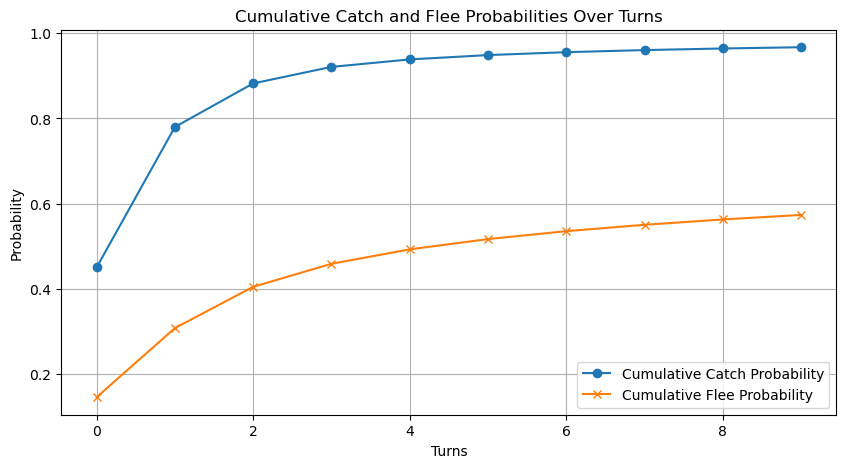

Actions taken: ['mud', 'mud', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait']



In [28]:
import numpy as np
import matplotlib.pyplot as plt

def apply_stage_modifier(stage):
    if stage >= 0:
        return (2 + stage) / 2
    else:
        return 2 / (2 - stage)

def setup_markov_chain(base_flee_rate, base_catch_rate, flee_stage=0, catch_stage=0, max_turns=10):
    flee_progress = []
    catch_progress = []
    actions_taken = []

    state_flee = np.array([1.0, 0.0])
    state_catch = np.array([1.0, 0.0])

    for t in range(max_turns):
        # Evaluate each action's expected effect on future state
        expected_values = {}

        for action_try in ["ball", "bait", "mud"]:
            fs_temp = flee_stage
            cs_temp = catch_stage

            if action_try == "bait":
                fs_temp -= 1
                cs_temp -= 0.9
            elif action_try == "mud":
                cs_temp += 1
                fs_temp += 0.9

            flee_mod = apply_stage_modifier(fs_temp)
            catch_mod = apply_stage_modifier(cs_temp)

            flee_rate = min(1.0, base_flee_rate * flee_mod)
            catch_rate = min(1.0, base_catch_rate * catch_mod)

            T_flee = np.array([[1 - flee_rate, flee_rate], [0, 1]])
            T_catch = np.array([[1 - catch_rate, catch_rate], [0, 1]])

            # Simulate 1 step with each action
            temp_state_flee = state_flee @ T_flee
            temp_state_catch = state_catch @ T_catch

            expected_catch_gain = temp_state_catch[1] - state_catch[1]
            expected_flee_loss = temp_state_flee[1] - state_flee[1]

            # Objective: maximize catch while minimizing flee
            score = expected_catch_gain - expected_flee_loss
            expected_values[action_try] = score

        # Choose best action
        action = max(expected_values, key=expected_values.get)

        # Apply effects
        if action == "bait":
            flee_stage -= 1
            catch_stage -= 0.9
            actions_taken.append("bait")
        elif action == "mud":
            catch_stage += 1
            flee_stage += 0.9
            actions_taken.append("mud")
        else:  # "ball"
            actions_taken.append("ball")

        flee_mod = apply_stage_modifier(flee_stage)
        catch_mod = apply_stage_modifier(catch_stage)
        flee_rate = min(1.0, base_flee_rate * flee_mod)
        catch_rate = min(1.0, base_catch_rate * catch_mod)

        T_flee = np.array([[1 - flee_rate, flee_rate], [0, 1]])
        T_catch = np.array([[1 - catch_rate, catch_rate], [0, 1]])

        state_flee = state_flee @ T_flee
        state_catch = state_catch @ T_catch

        prob_alive = state_flee[0] * state_catch[0]
        prob_caught = 1 - state_catch[0]
        prob_fled = 1 - state_flee[0]

        catch_progress.append(prob_caught)
        flee_progress.append(prob_fled)

    # Plot
    turns = np.arange(max_turns)
    plt.figure(figsize=(10, 5))
    plt.plot(turns, catch_progress, label='Cumulative Catch Probability', marker='o')
    plt.plot(turns, flee_progress, label='Cumulative Flee Probability', marker='x')
    plt.title('Cumulative Catch and Flee Probabilities Over Turns')
    plt.xlabel('Turns')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Actions taken: {actions_taken}\n")
    return {
        "catch_progress": catch_progress,
        "flee_progress": flee_progress,
        "final_alive_prob": prob_alive,
        "final_catch_prob": prob_caught,
        "final_flee_prob": prob_fled
    }

# Example use
results = setup_markov_chain(0.1, 0.3, flee_stage=0, catch_stage=0, max_turns=10)


Testing adaptive strategy with different base catch rates:


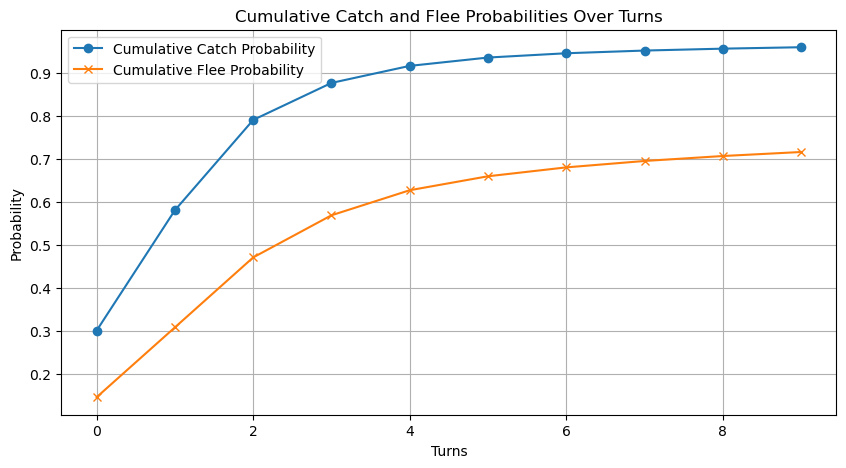

Actions taken: ['mud', 'mud', 'mud', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait']

Base catch rate 0.2 - Final catch probability: 0.959


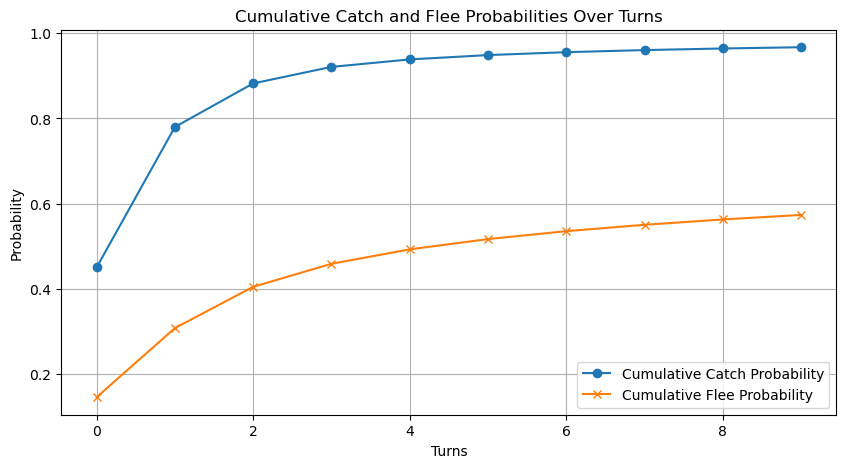

Actions taken: ['mud', 'mud', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait']

Base catch rate 0.3 - Final catch probability: 0.967


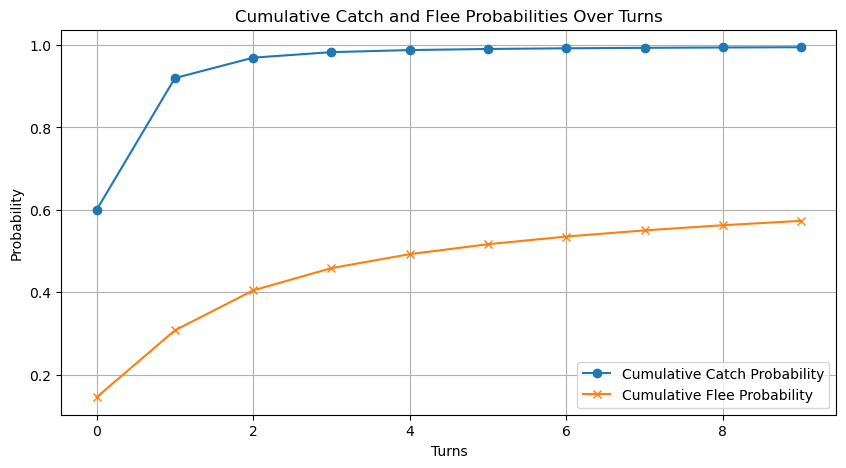

Actions taken: ['mud', 'mud', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait', 'bait']

Base catch rate 0.4 - Final catch probability: 0.995


In [ ]:
# Test with different base catch rates to see how the adaptive strategy responds
print("Testing adaptive strategy with different base catch rates:")
print("=" * 50)

# Test with lower catch rate
results_low = setup_markov_chain(0.1, 0.2, flee_stage=0, catch_stage=0, max_turns=10)
final_diff_low = results_low['final_catch_prob'] - results_low['final_flee_prob']
print(f"Base catch rate 0.2 - Final catch probability: {results_low['final_catch_prob']:.3f}")
print(f"                   - Final flee probability: {results_low['final_flee_prob']:.3f}")
print(f"                   - Final vertical difference (catch - flee): {final_diff_low:.3f}")

# Test with medium catch rate (your original)
results_med = setup_markov_chain(0.1, 0.3, flee_stage=0, catch_stage=0, max_turns=10)
final_diff_med = results_med['final_catch_prob'] - results_med['final_flee_prob']
print(f"Base catch rate 0.3 - Final catch probability: {results_med['final_catch_prob']:.3f}")
print(f"                   - Final flee probability: {results_med['final_flee_prob']:.3f}")
print(f"                   - Final vertical difference (catch - flee): {final_diff_med:.3f}")

# Test with higher catch rate
results_high = setup_markov_chain(0.1, 0.4, flee_stage=0, catch_stage=0, max_turns=10)
final_diff_high = results_high['final_catch_prob'] - results_high['final_flee_prob']
print(f"Base catch rate 0.4 - Final catch probability: {results_high['final_catch_prob']:.3f}")
print(f"                   - Final flee probability: {results_high['final_flee_prob']:.3f}")
print(f"                   - Final vertical difference (catch - flee): {final_diff_high:.3f}")

print("\n" + "=" * 50)
print("Summary of final vertical differences:")
print(f"Catch rate 0.2: {final_diff_low:.3f}")
print(f"Catch rate 0.3: {final_diff_med:.3f}")
print(f"Catch rate 0.4: {final_diff_high:.3f}")